<a href="https://colab.research.google.com/github/gwangjinjeong/Pytorch/blob/master/basic/01_Differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiation in PyTorch

## 0. Preparation

In [0]:
import torch 
import matplotlib.pylab as plt

## 1. Derivatives

***Tensor***   
패키지의 중심에는 `torch.Tensor` 클래스가 있습니다. 만약 `.requires_grad` 속성을 **True** 로 설정하면, 그 **tensor**에서 이뤄진 모든 연산들을 추적(track)하기 시작합니다.
   
계산이 완료된 후 `.backward()` 를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있습니다. 이 Tensor의 변화도는 .grad 속성에 누적됩니다.

.requires_grad_( ... ) 는 기존 Tensor의 requires_grad 값을 바꿔치기 (in-place)하여 변경합니다. 입력값이 지정되지 않으면 기본값은 False 입니다.   
$y=x^{2}+2x+1$ 를 계산해본다면..

In [0]:
x = torch.tensor(2.0, requires_grad = True)
print(x)
y = x ** 2 + 2 * x + 1
print(y)

tensor(2., requires_grad=True)
tensor(9., grad_fn=<AddBackward0>)


도함수를 계산하기 위해서는 Tensor 의 `.backward()` 를 호출하면 됩니다. 만약 Tensor 가 스칼라(scalar)인 경우(예. 하나의 요소 값만 갖는 등)에는 `backward` 에 인자를 정해줄 필요가 없습니다. 하지만 여러 개의 요소를 갖고 있을 때는 tensor의 모양을 gradient 의 인자로 지정할 필요가 있습니다.

$y=x^{2}+2x+1$

In [0]:
# Calculate the y = x^2 + 2x + 1, then find the derivative 

x = torch.tensor(2.0, requires_grad = True)
y = x ** 2 + 2 * x + 1
print(y)
y.backward()
print(x.grad)

tensor(9., grad_fn=<AddBackward0>)
tensor(6.)


$\frac{\mathrm{dy(x)}}{\mathrm{dx}}=2x+2$

$\frac{\mathrm{dy(x=2)}}{\mathrm{dx}}=2(2)+2=6$

In [0]:
class SQ(torch.autograd.Function):

    @staticmethod
    def forward(ctx,i):
        result=i**2
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i, = ctx.saved_tensors
        grad_output = 2*i
        return grad_output

In [0]:
x=torch.tensor(2.0,requires_grad=True )
sq=SQ.apply

y=sq(x)
y
print(y.grad_fn)
y.backward()
x.grad

tensor(4.)

##2. Partial Derivatives

$f(u,v)=vu+u^{2}$

In [21]:
u = torch.tensor(1.0,requires_grad=True)
v = torch.tensor(2.0,requires_grad=True)
f = u * v + u ** 2
print(f)

tensor(3., grad_fn=<AddBackward0>)


$f(u=1,v=2)=(2)(1)+1^{2}=3$

`u` 편미분값 과 `v`편미분 한 값

In [22]:
f.backward()
print(u.grad)

tensor(4.)


$\frac{\mathrm{\partial f(u,v)}}{\partial {u}}=v+2u$

$\frac{\mathrm{\partial f(u=1,v=2)}}{\partial {u}}=2+2(1)=4$

$\frac{\mathrm{\partial f(u,v)}}{\partial {v}}=u$

$\frac{\mathrm{\partial f(u=1,v=2)}}{\partial {v}}=1$

## 3. detach


   
Tensor가 기록을 추적하는 것을 중단하게 하려면, `.detach()` 를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있습니다.

In [0]:
x = torch.linspace(-10, 10, 10, requires_grad = True)
Y = x ** 2
y = torch.sum(x ** 2)

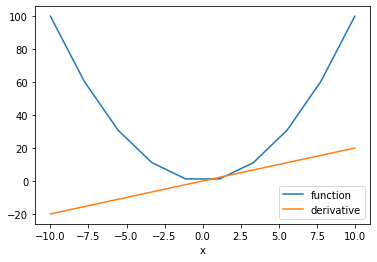

In [0]:
y.backward()

plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'function')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'derivative')
plt.xlabel('x')
plt.legend()
plt.show()

`relu`를 예로 들어보자

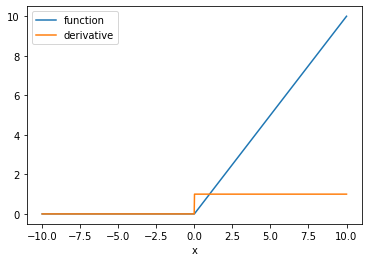

In [0]:
x = torch.linspace(-10, 10, 1000, requires_grad = True)
Y = torch.relu(x)
y = Y.sum()
y.backward()
plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'function')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'derivative')
plt.xlabel('x')
plt.legend()
plt.show()


기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해, 코드 블럭을 `with torch.no_grad():` 로 감쌀 수 있습니다. 이는 특히 변화도(gradient)는 필요없지만, requires_grad=True 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용합니다.

**Autograd** 구현에서 매우 중요한 클래스가 하나 더 있는데, 이것은 바로 `Function` 클래스입니다.

`Tensor` 와 `Function` 클래스는 서로 연결되어 있으며, 모든 연산 과정을 부호화(encode)하여 순환하지 않는 그래프(acyclic graph)를 생성합니다. 각 tensor는 `.grad_fn` 속성을 갖고 있는데, 이는 `Tensor` 를 생성한 Function 을 참조하고 있습니다. (단, 사용자가 만든 Tensor는 예외로, 이 때 `grad_fn` 은 None 입니다.)